<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>
<h1 align=center><font size = 5>Convolutional Neural Network Simple example </font></h1> 


<h3>Objective for this Notebook</h3>    
<h5> 1. Learn Convolutional Neural Network</h5>
<h5> 2. Define Softmax , Criterion function, Optimizer and Train the  Model</h5>    


# Table of Contents


<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Helper Functions </a></li>
<li><a href="#ref1"> Prepare Data </a></li>
<li><a href="#ref2">Convolutional Neural Network </a></li>
<li><a href="#ref3">Define Softmax , Criterion function, Optimizer and Train the  Model</a></li>
<li><a href="#ref4">Analyse Results</a></li>

<br>


</div>

<hr>


<a id="ref0"></a>
<a name="ref0"><h2 align=center>Helper Functions </h2></a>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(4)

In [2]:
# Function to plot out the parameters of the Convolutional Layers

def plot_channels(W):
    # number of output channels
    n_out = W.shape[0]
    # number of input channels
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index = 0
    in_index = 0
    # plot outputs as rows, inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index+1
            in_index = 0

        ax.imshow(W[out_index,in_index,:,:], vmin = w_min,
                  vmax = w_max, cmap = 'seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index+1

    plt.show()

In [3]:
# Plot out data sample

def show_data(dataset,sample):
    plt.imshow(dataset.x[sample,0,:,:].numpy(), cmap = 'gray')
    plt.title('y ='+str(dataset.y[sample].item()))
    plt.show()

In [5]:
# Create some toy data

class Data(Dataset):
    def __init__(self, N_images = 100, offset = 0, p = 0.9, train = False):
        """
        p:portability that pixel is wight
        N_images:number of images
        offset:set random vertical and horizontal offset images by sample should be less than 3
        """
        if train == True:
            np.random.seed(1)
        
        # make images multiple of 3
        N_images = 2*(N_images//2)
        images = np.zeros((N_images,1,11,11))
        start1 = 3
        start2 = 1
        self.y = torch.zeros(N_images).type(torch.long)

        for n in range(N_images):
            if offset > 0:
                low = int(np.random.randint(low = start1,
                                            high = start1+offset, size = 1))
                high = int(np.random.randint(low = start2,
                                             high = start2+offset, size = 1))
            else:
                low = 4
                high = 1
        
            if n<=N_images//2:
                self.y[n] = 0
                images[n, 0, high:high+9, low:low+3] = np.random.binomial(1, p, (9,3))
            elif  n>N_images//2:
                self.y[n] = 1
                images[n, 0, low:low+3, high:high+9] = np.random.binomial(1, p, (3,9))
        
        
        self.x = torch.from_numpy(images).type(torch.FloatTensor)
        self.len = self.x.shape[0]
        del(images)
        np.random.seed(0)
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [6]:
# Define function to plot out the activations of the Convolutional layers

def plot_activations(A, number_rows = 1,name = ""):
    A=A[0,:,:,:].detach().numpy()
    n_activations = A.shape[0]

    print(n_activations)
    A_min = A.min().item()
    A_max = A.max().item()

    if n_activations == 1:
        # Plot the image
        plt.imshow(A[0,:], vmin = A_min, vmax = A_max, cmap = 'seismic')

    else:
        fig, axes = plt.subplots(number_rows, n_activations//number_rows)
        fig.subplots_adjust(hspace = 0.4)
        for i,ax in enumerate(axes.flat):
            if i< n_activations:
                # Set the label for the sub-plot
                ax.set_xlabel("activation:{0}".format(i+1))
                # Plot the image
                ax.imshow(A[i,:], vmin = A_min, vmax = A_max, cmap = 'seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

In [7]:
# Utility function for computing output of convolutions takes tuple of (h,w) and returns tuple of (h,w)

def conv_output_shape(h_w, kernel_size = 1,
                      stride = 1, pad = 0, dilation = 1):
    # by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

<a id="ref1"></a>
<a name="ref1"><h2 align=center>Prepare Data </h2></a>


In [9]:
# Load the training dataset with 10000 samples
N_images = 10000
train_dataset = Data(N_images = N_images)

# Load the testing dataset
validation_dataset = Data(N_images = 1000, train = False)

### Data Visualization 


Each element in the rectangular  tensor corresponds to a number representing a pixel intensity  as demonstrated by  the following image.


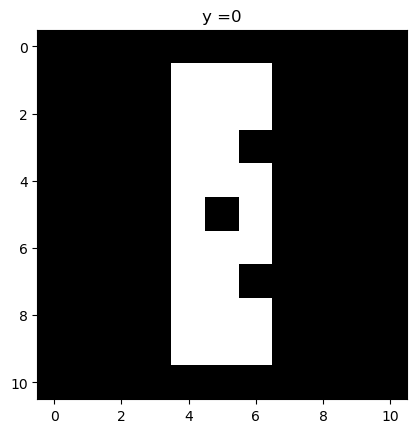

In [11]:
show_data(train_dataset, 0)

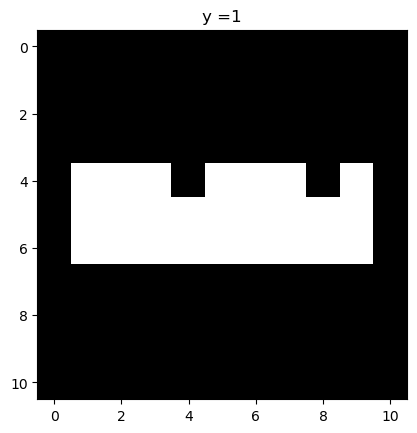

In [12]:
# We can print out the third label
show_data(train_dataset, N_images//2+2)

<a id="ref3"></a>
### Build a Convolutional Neral Network Class 


The input image is 11 x11, the following will change the size of the activations:
<ul>
<il>convolutional layer</il> 
</ul>
<ul>
<il>max pooling layer</il> 
</ul>
<ul>
<il>convolutional layer </il>
</ul>
<ul>
<il>max pooling layer </il>
</ul>

with the following parameters <code>kernel_size</code>, <code>stride</code> and <code> pad</code>.
We use the following  lines of code to change the image before we get to the fully connected layer.


In [13]:
out = conv_output_shape((11,11), kernel_size = 2,
                        stride = 1, pad = 0, dilation = 1)
print(out)

out1 = conv_output_shape(out, kernel_size = 2,
                         stride = 1, pad = 0, dilation = 1)
print(out1)

out2 = conv_output_shape(out1, kernel_size = 2,
                         stride = 1, pad = 0, dilation = 1)
print(out2)

out3 = conv_output_shape(out2, kernel_size = 2,
                         stride = 1, pad = 0, dilation = 1)
print(out3)

(10, 10)
(9, 9)
(8, 8)
(7, 7)


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for 1st and 2nd layer.


In [14]:
class CNN(nn.Module):
    def __init__(self, out_1 = 2, out_2 = 1):
        
        super(CNN,self).__init__()
        # 1st Convolutional layer
        self.cnn1 = nn.Conv2d(in_channels = 1,
                              out_channels = out_1,kernel_size = 2, padding = 0)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 1)

        # 2nd Convolutional layer
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2,
                              kernel_size = 2, stride = 1, padding = 0)
        
        # Max pooling
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 1)

        # Fully connected layer
        self.fc1 = nn.Linear(out_2*7*7,2)
        
    def forward(self, x):
        # 1st Convolutional layer
        x = self.cnn1(x)
        # Activation function
        x = torch.relu(x)
        # max pooling
        x = self.maxpool1(x)
        
        # 2nd Convolutional layer
        x = self.cnn2(x)
        # Activation function
        x = torch.relu(x)
        # Max pooling
        x = self.maxpool2(x)
        
        # Flatten output
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc1(x)
        return x
    
    def activations(self, x):
        # outputs activation this is not necessary just for fun
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out = self.maxpool2(a2)
        out = out.view(out.size(0), -1)
        return z1, a1, z2, a2, out

<a name="ref3"><h2> Define the Convolutional Neural Network Classifier, Criterion Function, Optimizer and Train the  Model  </h2></a> 

In [15]:
# 2 output channels for the 1st layer, and 1 outputs channel for the 2nd layer

model = CNN(2, 1)

In [16]:
# See the model parameters with the object

model

CNN(
  (cnn1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

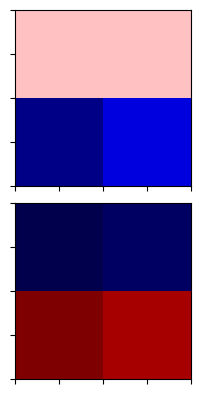

In [17]:
# Plot model parameters for the kernels before training the kernels
# The kernels are initialized randomly

plot_channels(model.state_dict()['cnn1.weight'])

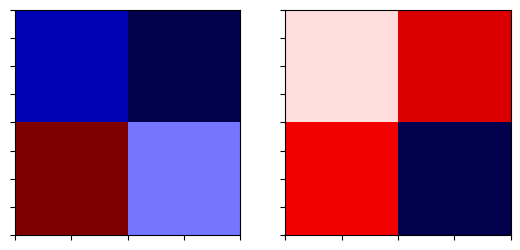

In [18]:
plot_channels(model.state_dict()['cnn2.weight'])

In [19]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer class
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [20]:
# Create data loaders for train and validation datasets
train_loader = DataLoader(dataset = train_dataset, batch_size = 10)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 20)

In [21]:
# Train the model and determine validation accuracy (This may take a long time!!!)

n_epochs = 10
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)
cost = 0

for epoch in range(n_epochs):
    cost = 0
    for x, y in train_loader:
        # Clear gradient
        optimizer.zero_grad()
        # Make prediction
        z = model(x)
        # Calculate loss
        loss = criterion(z,y)
        # Calculate gradients of parameters
        loss.backward()
        # Update parameters
        optimizer.step()
        cost+=loss.item()
    cost_list.append(cost)

    correct = 0
    # Perform prediction on the validation data
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _,yhat = torch.max(z.data,1)
        correct+=(yhat == y_test).sum().item()

    accuracy = correct/N_test
    accuracy_list.append(accuracy)

<a id="ref4"></a>
<a name="ref4"><h2 align=center>Analyse Results</h2></a>


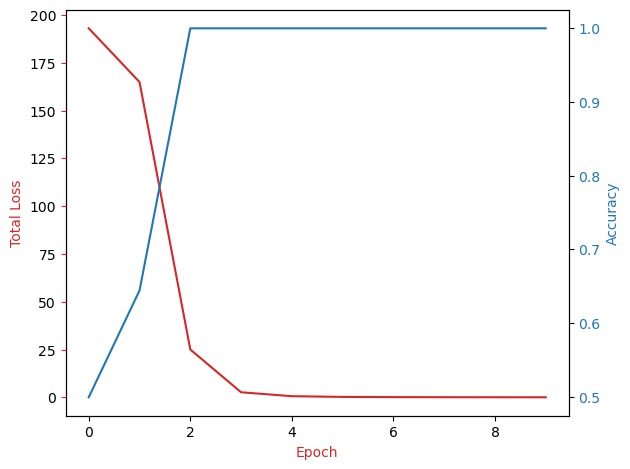

In [22]:
# Plot the loss and accuracy on the validation data

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color = color)
ax1.set_xlabel('Epoch', color = color)
ax1.set_ylabel('Total Loss', color = color)
ax1.tick_params(axis = 'y', color = color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color = color)
ax2.plot(accuracy_list, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)
fig.tight_layout()

In [23]:
# View the results of the parameters for the Convolutional layers
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3888,  0.5008],
          [-0.0477, -0.0855]]],


        [[[-0.4323, -0.2863],
          [ 0.9211,  0.8493]]]])

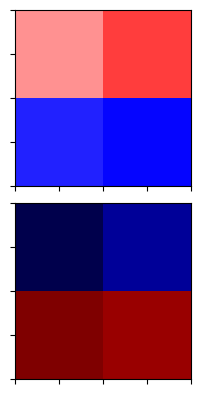

In [24]:
plot_channels(model.state_dict()['cnn1.weight'])

In [25]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.3888,  0.5008],
          [-0.0477, -0.0855]]],


        [[[-0.4323, -0.2863],
          [ 0.9211,  0.8493]]]])

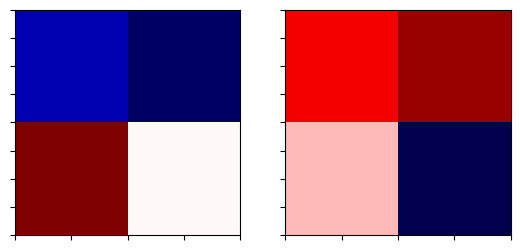

In [26]:
plot_channels(model.state_dict()['cnn2.weight'])

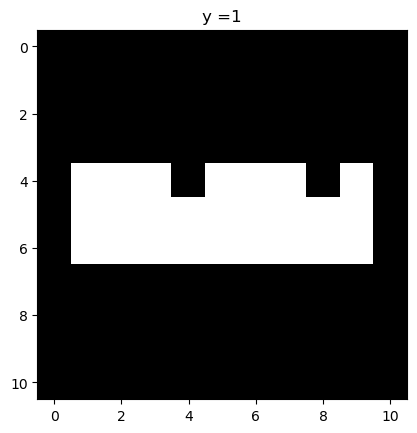

In [27]:
# Consider the following sample

show_data(train_dataset, N_images//2+2)

In [28]:
# Determine the activations

out = model.activations(train_dataset[N_images//2+2][0].view(1,1,11,11))
out = model.activations(train_dataset[0][0].view(1,1,11,11))

2


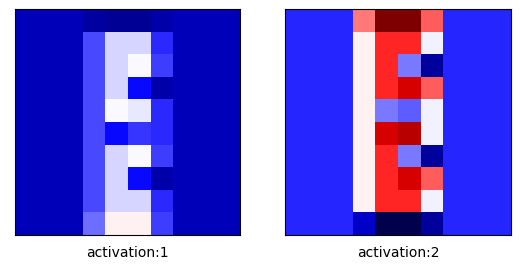

In [29]:
# Plot them out

plot_activations(out[0], number_rows = 1, name = 'feature map')
plt.show()

1


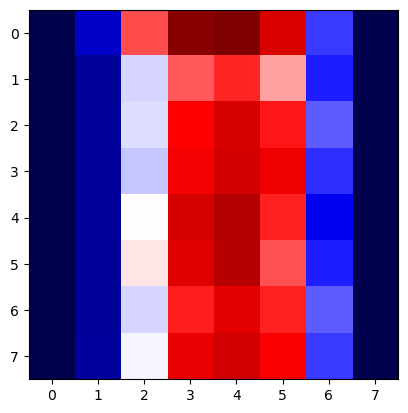

In [30]:
plot_activations(out[2], number_rows = 1, name = '2nd feature map')
plt.show()

1


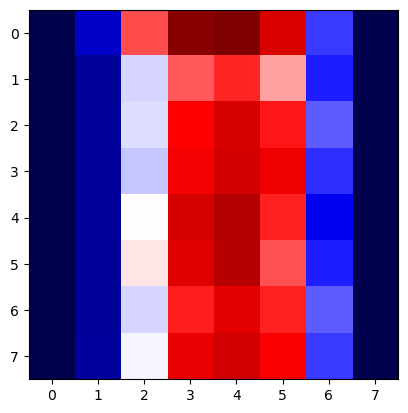

In [31]:
plot_activations(out[3], number_rows = 1, name = 'first feature map')
plt.show()

In [32]:
# Save the output of the activation after flattening

out1 = out[4][0].detach().numpy()

In [33]:
# do the same for a sample where y=0

out0 = model.activations(
    train_dataset[100][0].view(1,1,11,11))[4][0].detach().numpy()
out0

array([0.74286526, 1.7852224 , 2.5095966 , 2.542151  , 2.542151  ,
       2.2080631 , 1.0020232 , 0.599458  , 1.4955459 , 2.1564965 ,
       2.2978835 , 2.2978835 , 1.9130142 , 0.96670747, 0.599458  ,
       1.4955459 , 2.1124332 , 2.2791    , 2.2791    , 1.9122138 ,
       1.1047955 , 0.599458  , 1.3521385 , 1.9661636 , 2.087604  ,
       2.087604  , 1.9159286 , 1.1047955 , 0.599458  , 1.3521385 ,
       1.9661636 , 2.0746133 , 2.0746133 , 1.9159286 , 1.0020232 ,
       0.599458  , 1.3521385 , 1.8227565 , 1.8227565 , 1.8227565 ,
       1.5909786 , 0.838298  , 0.6166177 , 1.4248364 , 1.9210916 ,
       1.9210916 , 1.9210916 , 1.672154  , 0.8639351 ], dtype=float32)

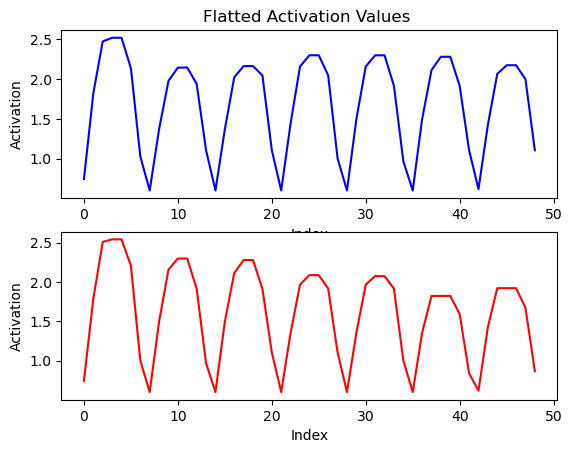

In [34]:
plt.subplot(2, 1, 1)
plt.plot(out1, 'b')
plt.title('Flatted Activation Values ')
plt.ylabel('Activation')
plt.xlabel('Index')
plt.subplot(2, 1, 2)
plt.plot(out0, 'r')
plt.xlabel('Index')
plt.ylabel('Activation')
plt.show()

<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Srishti  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>
-->

## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
